# Understand the Problem:

## Project Objective:

Our primary goal is to develop predictive models capable of estimating short-term volatility for a diverse range of stocks across various sectors in the financial market.

## Background:

Volatility plays a pivotal role in financial markets as it directly influences the pricing of financial instruments like options. Options, which are financial contracts granting the holder the right (but not the obligation) to buy or sell an underlying asset at a predetermined price in the future, are particularly sensitive to the volatility of the underlying asset. Accurate volatility prediction is essential for making informed investment decisions and managing financial risk.

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Exploration:

We begin by exploring the data required for this project. First, we load the training and test datasets:

In [2]:
data_dir = "./optiver-realized-volatility-prediction/"

In [3]:
# Load training data
train_data = pd.read_csv(data_dir + "train.csv")

# Display a sample of the training data
print("Sample of the training data:")
print(train_data.head())

# Load test data
test_data = pd.read_csv(data_dir + "test.csv")

# Display a sample of the test data
print("\nSample of the test data:")
print(test_data.head())

Sample of the training data:
   stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445
2         0       16  0.002168
3         0       31  0.002195
4         0       62  0.001747

Sample of the test data:
   stock_id  time_id row_id
0         0        4    0-4
1         0       32   0-32
2         0       34   0-34


#### In the test dataset, we notice that the submission file's row_id is composed of the stock_id and time_id connected by a hyphen (-)

#### Additionally, the test dataset includes book_test.parquet and trade_test.parquet. We explore these datasets as well:

In [4]:
# Load book_test data
book_test_data = pd.read_parquet(data_dir + "book_test.parquet/stock_id=0")
book_test_data

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,4,0,1.000049,1.000590,0.999656,1.000639,91,100,100,24
1,4,1,1.000049,1.000590,0.999656,1.000639,91,100,100,20
2,4,5,1.000049,1.000639,0.999656,1.000885,290,20,101,15


In [5]:
# Load trade_test data
trade_test_data = pd.read_parquet(data_dir + "trade_test.parquet/stock_id=0")
trade_test_data

,time_id,seconds_in_bucket,price,size,order_count
0,4,7,1.000344,1,1
1,4,24,1.000049,100,7
2,4,27,1.000059,100,3


### For the training dataset, we explore data related to a specific stock (stock_id = 0) as an example:

In [6]:
# Explore training data for Stock 0 - book data
book_train_data_0 = pd.read_parquet(data_dir + "book_train.parquet/stock_id=0")
book_train_data_0.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100


In [7]:
# Explore training data for Stock 0 - trade data
trade_train_data_0 = pd.read_parquet(data_dir + "trade_train.parquet/stock_id=0")
trade_train_data_0.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


# Initial Analysis

### We calculate the Weighted Average Price (WAP) for stock 0:

This is a commonly used metric that gives a representation of the average price at which a stock is traded over an interval.

In [8]:
book_train_data_0['wap'] = (book_train_data_0['bid_price1'] * book_train_data_0['ask_size1'] +
                                book_train_data_0['ask_price1'] * book_train_data_0['bid_size1']) / (
                                       book_train_data_0['bid_size1']+ book_train_data_0['ask_size1'])

### The logarithm of the ratio between two consecutive WAP:

This represents the percentage change in the value of a financial instrument. It can provide insights into volatility, as higher volatility often corresponds to larger log returns (both positive and negative).

In [9]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

book_train_data_0.loc[:,'log_return'] = log_return(book_train_data_0['wap'])
book_train_data_0 = book_train_data_0[~book_train_data_0['log_return'].isnull()]

In [10]:
book_train_data_0.describe()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap,log_return
count,917552.000000,917552.000000,917552.000000,917552.000000,917552.000000,917552.000000,917552.000000,917552.000000,917552.000000,917552.000000,917552.000000,9.175520e+05
mean,15980.074318,293.692335,0.999495,1.000526,0.999298,1.000727,113.717223,100.825213,86.770333,83.203049,1.000043,-3.178342e-09
std,9381.769206,173.596264,0.003668,0.003696,0.003702,0.003743,108.657206,109.063873,90.602595,94.968438,0.003667,4.973726e-04
min,5.000000,0.000000,0.938241,0.944337,0.937213,0.944456,1.000000,1.000000,1.000000,1.000000,0.939348,-3.974106e-02
25%,7759.000000,142.000000,0.998368,0.999223,0.998184,0.999390,22.000000,14.000000,18.000000,14.000000,0.998802,-4.088737e-05
50%,15772.000000,292.000000,0.999632,1.000331,0.999472,1.000496,100.000000,93.000000,100.000000,90.000000,1.000003,0.000000e+00
75%,23834.000000,444.000000,1.000753,1.001560,1.000587,1.001745,157.000000,117.000000,102.000000,102.000000,1.001199,4.251642e-05
max,32767.000000,599.000000,1.045641,1.056892,1.043756,1.057676,3221.000000,16608.000000,4391.000000,16608.000000,1.053275,5.925392e-02


#### MIN WAP for stock 0 is: 0.939348, Max WAP for stock 0 is: 1.053275, and Mean WAP for stock 0 is: 1.000043

## Engineered features:
**Helps to enhance the prediction capability of the model**

**Rolling Averages:**
Simple Moving Average (SMA): A moving average smoothens price data to create a single flowing line.
Exponential Moving Average (EMA): Gives more weight to the most recent prices and thus reacts more quickly to price changes than the SMA.


**Historical Volatility:**
Rolling Standard Deviation: Use the rolling standard deviation of the log returns as an estimation of historical volatility. The window size can vary based on the prediction's time horizon.
Bollinger Bands: Bands that are two standard deviations away from a simple moving average.
Momentum: Difference in the stock's current price and its price a certain number of periods ago.


**Relative Strength Index (RSI):** Measures the speed and change of price movements. RSI oscillates between 0 and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.


**Order Imbalance:** The difference between the number of buy and sell orders over a specific time window.

In [11]:
# # 1. Rolling Averages:
# window_size = 50  # you can adjust this as needed
# book_train_data_0['sma'] = book_train_data_0['wap'].rolling(window=window_size).mean()
# book_train_data_0['ema'] = book_train_data_0['wap'].ewm(span=window_size, adjust=False).mean()

# # 2. Historical Volatility:
# book_train_data_0['rolling_std'] = book_train_data_0['log_return'].rolling(window=window_size).std()

# # 3. Bollinger Bands:
# book_train_data_0['bollinger_upper'] = book_train_data_0['sma'] + 2*book_train_data_0['rolling_std']
# book_train_data_0['bollinger_lower'] = book_train_data_0['sma'] - 2*book_train_data_0['rolling_std']

# # 4. Momentum:
# book_train_data_0['momentum'] = book_train_data_0['wap'] - book_train_data_0['wap'].shift(window_size)

# # 5. RSI:
# delta = book_train_data_0['wap'].diff(1)
# gain = (delta.where(delta > 0).fillna(0))
# loss = (-delta.where(delta < 0).fillna(0))
# avg_gain = gain.rolling(window=window_size).mean()
# avg_loss = loss.rolling(window=window_size).mean()
# rs = avg_gain / avg_loss
# book_train_data_0['rsi'] = 100 - (100 / (1 + rs))

# # 6. Order Imbalance:
# book_train_data_0['order_imbalance'] = (book_train_data_0['bid_size1'] + book_train_data_0['bid_size2']) - (book_train_data_0['ask_size1'] + book_train_data_0['ask_size2'])

# # Drop NaN values:
# book_train_data_0.dropna(inplace=True)

## Plotting Graphs:

### We select time_id 5 for plotting:

In [12]:
book_stock0_timeid5 = book_train_data_0[book_train_data_0['time_id'] == 5]
book_stock0_timeid5.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap,log_return
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,1.001448,0.000014
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,1.001448,0.000000
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443,-0.000005
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,1.001443,0.000000
5,5,11,1.001422,1.002301,1.00137,1.002405,3,100,2,100,1.001448,0.000005


In [13]:
trade_stock0_timeid5 = trade_train_data_0[trade_train_data_0['time_id'] == 5]
trade_stock0_timeid5.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


In [14]:
trade_stock0_timeid5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time_id            40 non-null     int16  
 1   seconds_in_bucket  40 non-null     int16  
 2   price              40 non-null     float32
 3   size               40 non-null     int32  
 4   order_count        40 non-null     int16  
dtypes: float32(1), int16(3), int32(1)
memory usage: 880.0 bytes


### Graph to visualize the relationship between Bid Price and Ask Price:

This plot depicts the relationship between bid and ask prices over time (specifically for time_id=5). It can help visualize the spread between buying and selling prices.

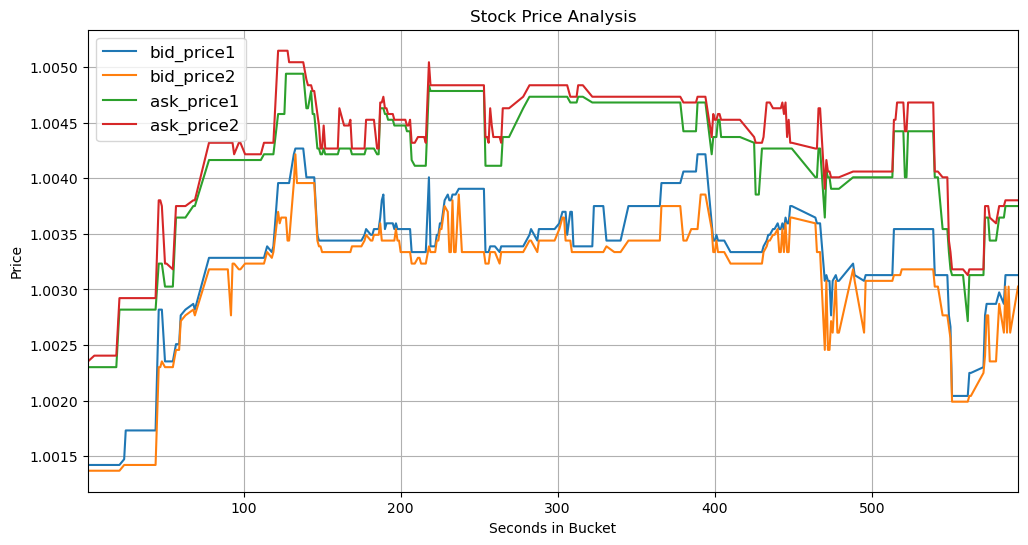

In [15]:
sample_labels = ["bid_price1", "bid_price2", "ask_price1", "ask_price2"]

plt.figure(figsize=(12, 6))

for label in sample_labels:
    plt.plot(book_stock0_timeid5["seconds_in_bucket"], book_stock0_timeid5[label], label=label)

plt.legend(fontsize=12)
plt.xlabel("Seconds in Bucket")
plt.ylabel("Price")
plt.title("Stock Price Analysis")
plt.grid(True)

plt.xlim([book_stock0_timeid5.seconds_in_bucket.min(),book_stock0_timeid5.seconds_in_bucket.max()]) # setting limits to x-axis

plt.show()

### Graph to visualize the relationship between Stock Price and WAP:

This visualization provides a comparative view between the stock's actual price and its weighted average price. It can be beneficial to understand how closely the traded prices are following the average pricing trend.

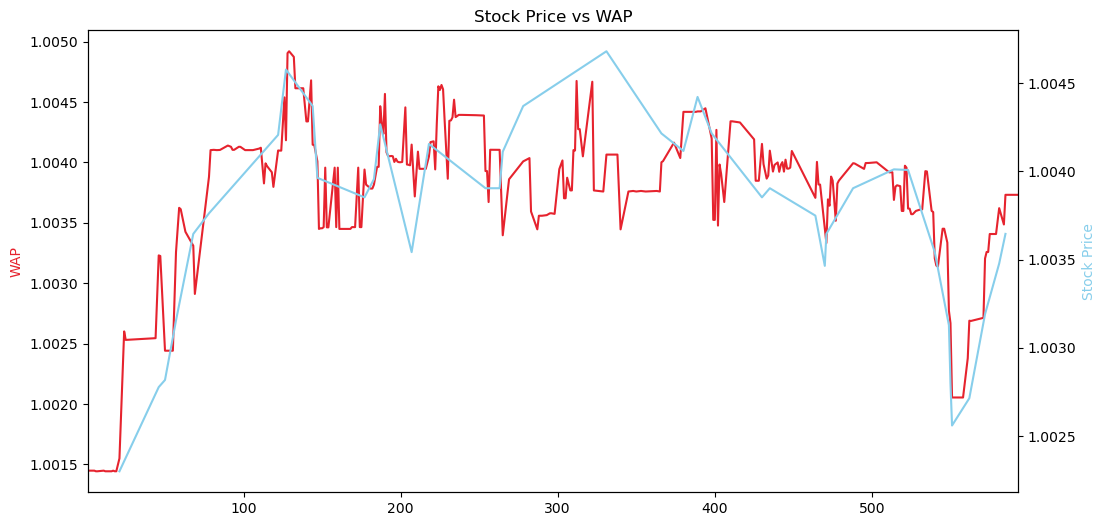

In [16]:
plt.figure(figsize=(12, 6))
plt.title('Stock Price vs WAP')

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.set_ylabel ('WAP', color='#E6232E')
ax2.set_ylabel ('Stock Price', color='skyblue')

ax1.set_xlim([book_stock0_timeid5.seconds_in_bucket.min(),book_stock0_timeid5.seconds_in_bucket.max()]) # setting limits to x-axis

ax1.plot(book_stock0_timeid5.seconds_in_bucket, book_stock0_timeid5.wap, color='#E6232E')
ax2.plot(trade_stock0_timeid5.seconds_in_bucket, trade_stock0_timeid5.price, color='skyblue')

#### The visualizations chosen give insights into how the stock behaves within small time frames. Any significant deviations between the bid and ask prices or between the stock price and WAP can be potential indicators of market events or anomalies.

### Graph to visualize the logarithm of the ratio between two consecutive WAP:

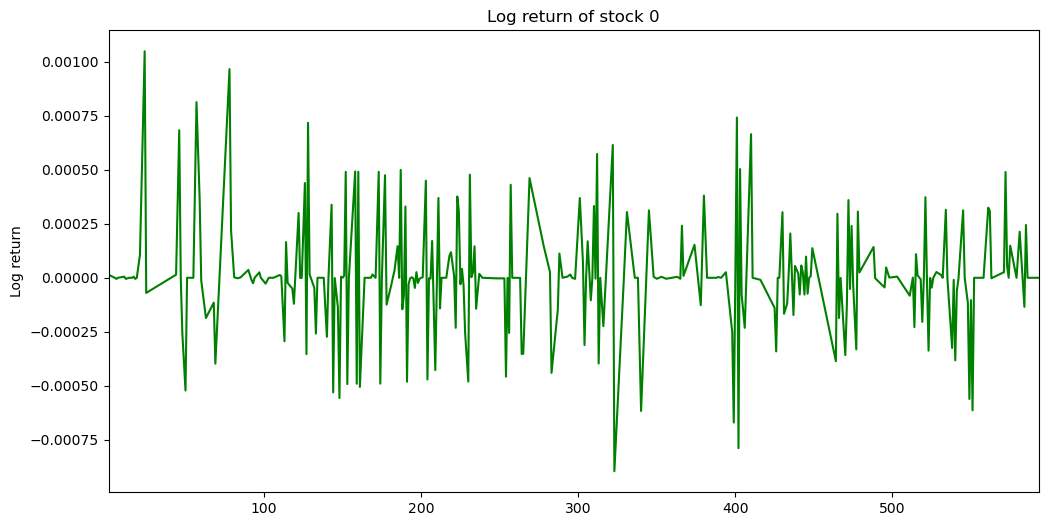

In [17]:
plt.figure(figsize=(12, 6))
plt.title('Log return of stock 0')

ax1 = plt.gca()

ax1.set_ylabel ('Log return')

ax1.set_xlim([book_stock0_timeid5.seconds_in_bucket.min(),book_stock0_timeid5.seconds_in_bucket.max()]) # setting limits to x-axis

ax1.plot(book_stock0_timeid5.seconds_in_bucket, book_stock0_timeid5.log_return, color='green')

### Correlation HeatMap:

In [18]:
merged_df = pd.merge(book_stock0_timeid5, trade_stock0_timeid5, on=['time_id', 'seconds_in_bucket'])

In [19]:
correlation_matrix = merged_df.corr()

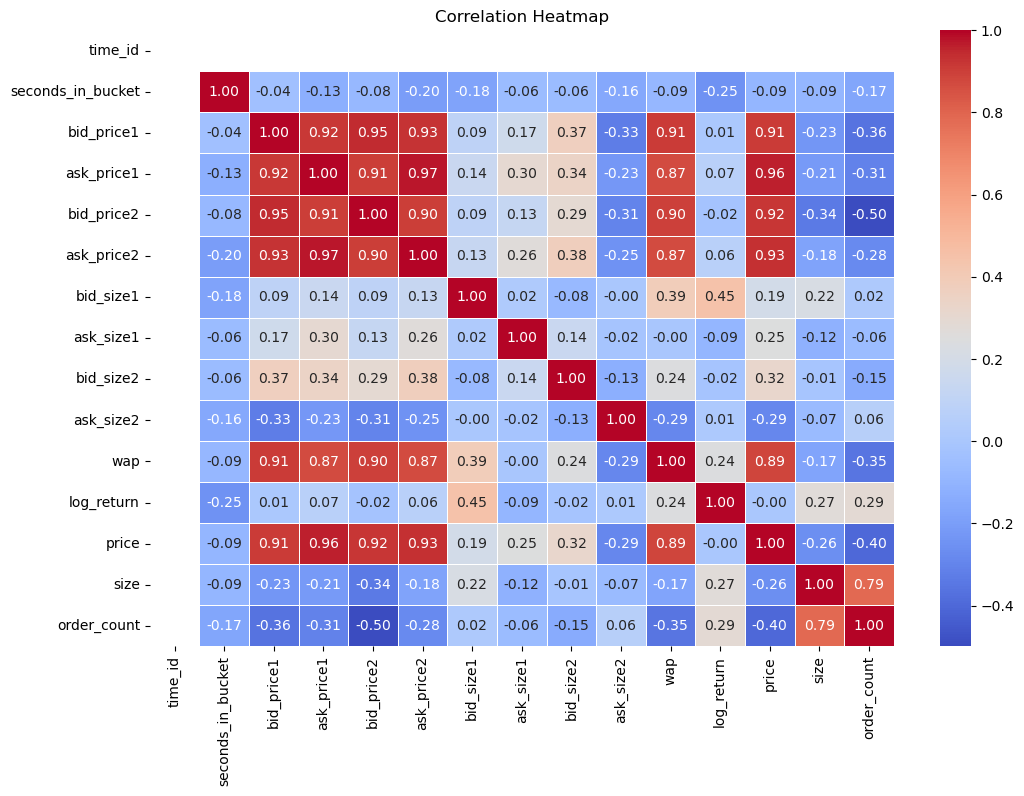

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

#### The correlation heatmap presented above reveals that our stock demonstrates a robust positive correlation with [bid_price1, ask_price1, bid_price2, ask_price2, wap], with an approximate 90% correlation coefficient. Conversely, there is a notable negative correlation of around 40% with the [order_count] variable.

# Aggregating All stocks: